<a href="https://colab.research.google.com/github/vibferreira/DL_UBS/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment

For this assignment, we ask you to train a deep learning model able to detect oil palm plantation in Planet images.
This is a binary classification task where label `0` means there is no oil palm plantation in the image, and `1` indicates the presence of an oil palm plantation.

Each image has a 3 meter spatial resolution, has 3 channels (RGB) and a size of 256 $\times$ 256 pixels.


You have access only to the train set, and we hold out an independent test set to evaluate your final classification performance (average F-Score).


The dataset has been collected from [Kaggle](https://www.kaggle.com/c/widsdatathon2019/data), and was proposed in the Women in Data Science Datathon 2019.

In [1]:
#-- connecting to Drive
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
!unzip '/content/drive/MyDrive/CDE_final_deep_learning/assignment-instructions.zip'
project_path = '/content/assignment'

Archive:  /content/drive/MyDrive/CDE_final_deep_learning/assignment-instructions.zip
  inflating: assignment/assignment.ipynb  
  inflating: assignment/traindata.csv  
  inflating: assignment/train.zip    


In [3]:
#-- unzip train.zip
!unzip {project_path}/train.zip -d {project_path}

Streaming output truncated to the last 5000 lines.
  inflating: /content/assignment/train/img_2677.jpg  
  inflating: /content/assignment/train/img_2678.jpg  
  inflating: /content/assignment/train/img_2679.jpg  
  inflating: /content/assignment/train/img_2680.jpg  
  inflating: /content/assignment/train/img_2681.jpg  
  inflating: /content/assignment/train/img_2682.jpg  
  inflating: /content/assignment/train/img_2683.jpg  
  inflating: /content/assignment/train/img_2684.jpg  
  inflating: /content/assignment/train/img_2685.jpg  
  inflating: /content/assignment/train/img_2686.jpg  
  inflating: /content/assignment/train/img_2687.jpg  
  inflating: /content/assignment/train/img_2688.jpg  
  inflating: /content/assignment/train/img_2689.jpg  
  inflating: /content/assignment/train/img_2690.jpg  
  inflating: /content/assignment/train/img_2691.jpg  
  inflating: /content/assignment/train/img_2692.jpg  
  inflating: /content/assignment/train/img_2693.jpg  
  inflating: /content/assignmen

## Reading the data

The information on the training data is stored in the csv file `traindata.csv`.

In [4]:
import pandas as pd
train_df = pd.read_csv(os.path.join(project_path, "traindata.csv"))
train_df

,img_id,has_oilpalm
0,train/img_0000.jpg,0
1,train/img_0001.jpg,0
2,train/img_0002.jpg,0
3,train/img_0003.jpg,0
4,train/img_0004.jpg,0
...,...,...
7672,train/img_7672.jpg,0
7673,train/img_7673.jpg,0
7674,train/img_7674.jpg,0
7675,train/img_7675.jpg,0


The ``img_id`` column indicates the relative path to the image and the ``has_oilpalm`` columns give the corresponding class index.

Let us now dowload the data and train a simple Random Forest algorithm on the flatten representation of the training images.
As the data are **big** (~12GB if we donwload them in a float64 numpy array), we will use here only a subset of the data.

In [5]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 46.5 MB/s 


In [6]:
import numpy as np
import rasterio

N = 500
#-- Getting the training dataset (X,y)
X = np.zeros((N,256*256*3), dtype=np.uint8)
y = np.zeros((N,), dtype=np.uint8)
train_rf_model = train_df.sample(n=N)
for n in range(N):
  X[n,:] = rasterio.open(os.path.join(project_path,train_rf_model.iloc[n]['img_id'])).read().flatten()
  y[n] = train_rf_model.iloc[n]['has_oilpalm']

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
#-- Training a RF model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=100, max_depth=25, oob_score=True, n_jobs=-1)
rf.fit(X,y)
print('OOB error: ', rf.oob_score_)

OOB error:  0.852


# Assignment instructions


This is now your turn to train the most accurate deep learning model you can.  

**Deadline**: January 16 2022 - 6 pm

You should upload your notebook on Moodle with your different experiments as well as a saved model that we can load and use to evaluate your performance on the test set.

Your notebook plays the role of a report. It should 
* describe the different experiments you have made
* include a summary of the results you have obtained 
* analyse these results
* include the code for only the main experiments.

We will pay attention to
* the design of the architecture,
* the explanation about the different experiments and how you get to the final results (summarize the information and the main issues you encountered and how you solved them, highlight the salient experiments) ,
* the cleanliness of the code.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset, WeightedRandomSampler # import DataLoader and TensorDataset

## Data Analysis

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.



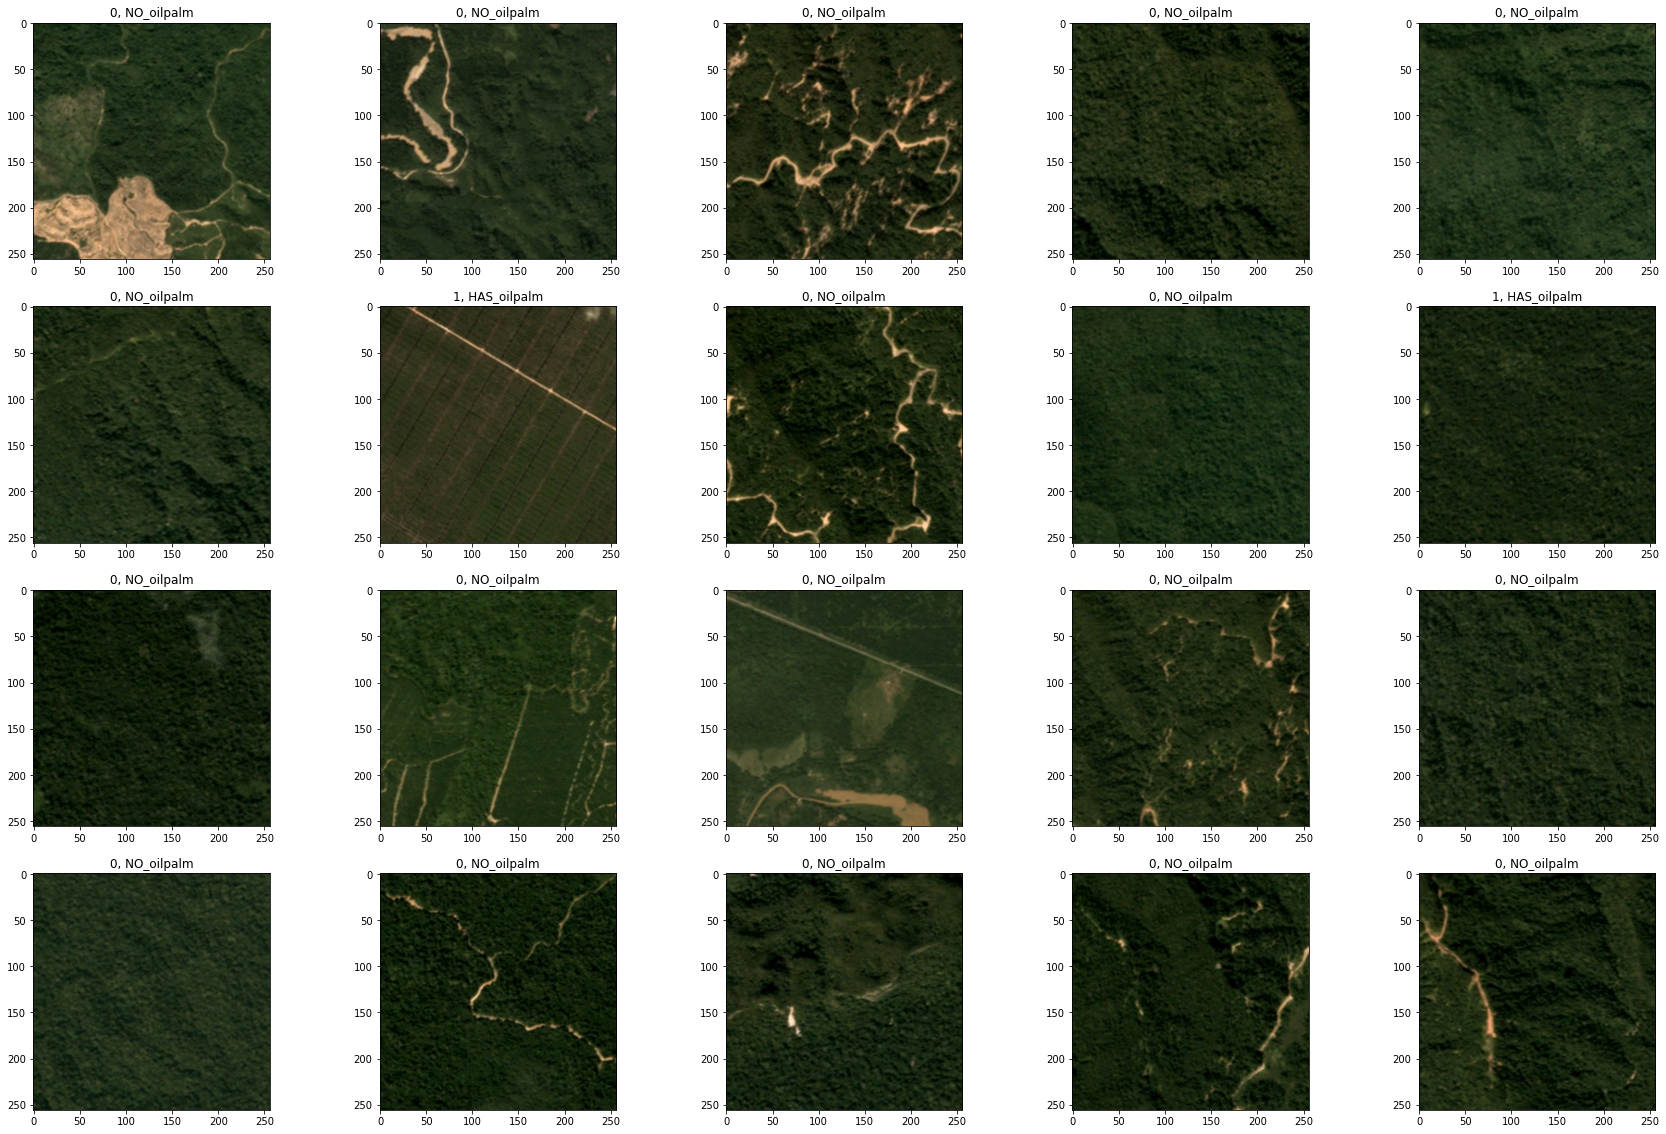

In [9]:
#@title Visualization
N = 20 # number of images 

X = np.zeros((N, 3, 256, 256), dtype=np.uint16)
y = np.zeros((N,), dtype=np.uint8)
train_rf_model = train_df.sample(n=N)

# Read the images 
for n in range(N):
  X[n,:] = rasterio.open(os.path.join(project_path,train_rf_model.iloc[n]['img_id'])).read()
  y[n] = train_rf_model.iloc[n]['has_oilpalm']
  # # Plot
  # plt.imshow(X[n,:].T)
  # plt.title(y[n])
  # plt.show()

# Plot
n_row = 4
n_col = 5
_, axs = plt.subplots(n_row, n_col, figsize=(30, 20))
axs = axs.flatten()
i = 0
for img, ax in zip(X, axs):
    ax.imshow(img.T)
    label = np.where(y[i] == 1, 'HAS_oilpalm', 'NO_oilpalm')
    ax.set_title(f'{y[i]}, {label}')
    i+=1
plt.show()

In [10]:
# Statistics 
class_count = train_df.groupby('has_oilpalm').count()
diff_classes = int(class_count.iloc[0] - class_count.iloc[1])
total = len(train_df)

print('Total N samples:', total)
print('Diff among classes: ', diff_classes)
class_count

Total N samples: 7677
Diff among classes:  5767


,img_id
has_oilpalm,
0,6722
1,955


In [11]:
# Summary Statistics
class_count.describe()

,img_id
count,2.000000
mean,3838.500000
std,4077.884807
min,955.000000
25%,2396.750000
50%,3838.500000
75%,5280.250000
max,6722.000000


In [12]:
# Viz 
pie = class_count.reset_index()
class_count['label'] = np.where(pie['has_oilpalm'] == 1, 'HAS_oilpalm', 'NO_oilpalm')
fig = px.pie(class_count, values='img_id', names='label', title=f'Data distribution')
fig.show()

In [13]:
# Quadruplicating Dataset 
has_oilpalm = train_df[(train_df['has_oilpalm'] == 1)]
no_oilpalm = train_df[(train_df['has_oilpalm'] == 0)]

has_oilpalm_hp_x4=pd.concat([has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm])

#Reindexing
train_df.index = pd.RangeIndex(len(train_df.index))
train_df.index = range(len(train_df.index))

train_df = pd.concat([has_oilpalm_hp_x4, no_oilpalm])
len(train_df)

12452

In [14]:
class_count = train_df.groupby('has_oilpalm').count()
pie = class_count.reset_index()
class_count['label'] = np.where(pie['has_oilpalm'] == 1, 'HAS_oilpalm', 'NO_oilpalm')
fig = px.pie(class_count, values='img_id', names='label', title=f'Data distribution')
fig.show()

In [15]:
train_df.index = pd.RangeIndex(len(train_df.index))
train_df.index = range(len(train_df.index))

# df = train_df[~train_df.index.duplicated()] 
# len(train_df)

## DataLoader, Normalization and Dealing with Unbalaced Dataset

Since we are working with a large dataset, the DataLoader class of PyTorch enables easy access to the samples by iterating around the dataset. In order to feed the DataLoader with the images and their corresponding labels, a custom Dataset ([CustomDataset class ](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)) was created. 

The dataset is normalised between 0 and 1 to reduce the skewness of the data, which helps to learn the patterns better and faster. 

As shown in the previous section, the dataset is fairly unbalaced, which may negatively impact the predictions, as the model does not have enough data on the unbalaced class to return accurate results. In addition, unbalaced datasets may be a problem when spliting the data as the less representative classes may not be in enough quantity to train or test the model. In order to minimize the impact of the unbalaced dataset, the samples were weighted according to their class distribution using the built-in pytorch function WeightedRandomSampler.

In [16]:
#@title Data Augmentation only in the minority class 

from torch.utils.data import Dataset
from torchvision.io import read_image

# # Defining a custom dataset 
# class CustomDataset(Dataset):
#   """ retrieves the dataset’s features and labels one sample at a time """
#   def __init__(self, path, df, transform_whole_data=None, transform_min_class=None):
#     self.path = path
#     self.transform_whole_data = transform
#     self.transform_min_class = transform_min_class
#     # self.data_samples = df
#     self.df = df

#   def __len__(self):
#     """returns the number of samples in the dataset"""
#     return len(self.df) 
               
#   def __getitem__(self, idx):
#     """ loads and returns a sample from the dataset at the given index idx """
#     # images
#     file_id = self.df['img_id'].iloc[idx]
#     img_path = os.path.join(self.path, file_id)
#     img = read_image(img_path)

#     # labels
#     label = self.df['has_oilpalm'].iloc[idx]

#     # where the transformations are passed to (WHOLE DATA)
#     if self.transform_whole_data:
#       img = self.transform_whole_data(img)

#       # where the transformations are passed to (MINORITY CLASS)
#       if label == 1 and self.transform_min_class:
#         img = self.transform_min_class(img)

#     return img, label

In [17]:
# Defining a custom dataset 
class CustomDataset(Dataset):
  """ retrieves the dataset’s features and labels one sample at a time """
  def __init__(self, path, df, transform=None):
    self.path = path
    self.transform = transform
    # self.data_samples = df
    self.df = df

  def __len__(self):
    """returns the number of samples in the dataset"""
    return len(self.df) 
               
  def __getitem__(self, idx):
    """ loads and returns a sample from the dataset at the given index idx """
    # images
    file_id = self.df['img_id'].iloc[idx]
    img_path = os.path.join(self.path, file_id)
    img = read_image(img_path)

    # labels
    label = self.df['has_oilpalm'].iloc[idx]

    # where the transformations are passed to (WHOLE DATA)
    if self.transform:
      img = self.transform(img)

    return img, label

In [18]:
# DataLoader
batch_size=32

# Normalisation
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor() # set to the range [0, 1]
            # transforms.Normalize(mean=(.5, .5, .5), # mean of each channel
            #                      std=(1=.5, .5, .5)) # std of each channel
            ])

# transform_minority = transforms.Compose([
#             transforms.RandomHorizontalFlip(p=0.5) 
#             ])

# Weighted Random Sampler
def weighted_random_sampler(target):
  """ Return sample weights based on the class distribution"""
  target = target['has_oilpalm']
  label_counts = np.bincount(target)
  labels_weights = 1. / label_counts
  samples_weight = torch.tensor([labels_weights[t] for t in target]).double()
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

  return sampler, samples_weight

# Split dataset into Train and Test
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffling the data
train, test = train_test_split(train_df, test_size=0.25, random_state=0)

# Total Dataset
print('Total dataset:', train_df.shape[0])

# Train
sampler_train, weight_train = weighted_random_sampler(train)
training_data = CustomDataset(project_path, train, transform=transform)
train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=sampler_train)

print('Total training:', len(training_data))

# Test
sampler_test, weights_test = weighted_random_sampler(test)
testing_data = CustomDataset(project_path, test, transform=transform)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, sampler=sampler_test)

print('Total testing:', len(testing_data))

# Weights
print('Weights:\n', {i:label for i, label in enumerate(np.unique(weights_test))})

Total dataset: 12452
Total training: 9339
Total testing: 3113
Weights:
 {0: 0.0005963029218843172, 1: 0.0006963788300835655}


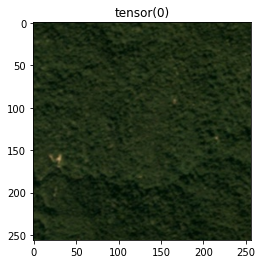

In [19]:
# Check DataLoader's content of first image in the Test Set
display = next(iter(train_dataloader))
img = display[0][0].T
title = display[1][0]
plt.imshow(img)
plt.title(title)
plt.show()

## Baseline Deep Learning Model - LeNET7
As a start point, LeNET7 was used to compare 

In [20]:
class LeNet7(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet7, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv4_bn = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv5_bn = nn.BatchNorm2d(128)

        #-- fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, n_classes)
        self.fc2_bn = nn.BatchNorm1d(128)

        # % of neurons to dropout
        self.conv5_bn = nn.Dropout2d(0.5)

    def forward(self, x):
        x=self.conv1(x)
        x = F.max_pool2d(F.relu(self.conv1_bn(x)), 2)
        x=self.conv2(x)
        x = F.max_pool2d(F.relu(self.conv2_bn(x)), 2)
        x=self.conv3(x)
        x = F.max_pool2d(F.relu(self.conv3_bn(x)), 2)
        x=self.conv4(x)
        x = F.max_pool2d(F.relu(self.conv4_bn(x)), 2)
        x=self.conv5(x)
        x = F.max_pool2d(F.relu(self.conv5_bn(x)), 2)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x= self.fc1(x)
        x = F.relu(self.fc1_bn(x))

        # Apply DropOut
        x = self.conv5_bn(x)

        logits = self.fc2(x)
        return logits

In [21]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
# Handy Functions

# Loss/Cost function
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y) # in relation to the class probability 

def train_epoch(model, 
                optimizer, 
                loss_func, 
                dataloader, 
                device):
  model.train()
  train_correct = 0
  train_loss = []

  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item()/len(x_train_batch))
  
  train_accuracy = train_correct/len(dataloader.dataset)
  mean_loss = sum(train_loss)/len(train_loss)

  return train_loss, train_accuracy, mean_loss

def val_epoch(model, 
              loss_func, 
              dataloader, 
              device, 
              scheduler=None):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch)

  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss   
  val_accuracy = val_correct/len(dataloader.dataset)

  # # Scheduler
  if scheduler:
    scheduler.step(val_loss)

  return val_loss, val_accuracy

def plot_comparison(train_dataloader, 
                    epochs, 
                    train_loss, 
                    val_loss, 
                    train_accuracy, 
                    val_accuracy):
  
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range(epochs*len(train_dataloader))),train_loss, label="train")
  plt.plot(list(range(0, epochs*len(train_dataloader),len(train_dataloader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(epochs)), train_accuracy, label="train")
  plt.plot(list(range(epochs)), val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

In [24]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = LeNet7(3, 2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, verbose = True)

for e in range(epochs):
    
  epoch_train_loss, epoch_train_accuracy, mean_loss = train_epoch(model, optimizer, loss_func, train_dataloader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, test_dataloader, device)
  print(f'epoch: {e} training loss: {mean_loss}')
  print(f'epoch: {e} val loss: {epoch_val_loss}')

  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

epoch: 0 training loss: 0.015927176899997255
epoch: 0 val loss: 0.013794537022149797
epoch: 1 training loss: 0.014082836995079909
epoch: 1 val loss: 0.033260725287812105
epoch: 2 training loss: 0.014292239879514551
epoch: 2 val loss: 0.013559140985394229
epoch: 3 training loss: 0.014912450522371489
epoch: 3 val loss: 0.0131614900768818
epoch: 4 training loss: 0.013953721976235607
epoch: 4 val loss: 0.014960708531619573
epoch: 5 training loss: 0.014043744105762054
epoch: 5 val loss: 0.01413257732637971
epoch: 6 training loss: 0.01375306940215575
epoch: 6 val loss: 0.013282810764760018
epoch: 7 training loss: 0.013894229263758532
epoch: 7 val loss: 0.012956872046319304
epoch: 8 training loss: 0.013547354737388368
epoch: 8 val loss: 0.016581242792176695
epoch: 9 training loss: 0.013084157065909879
epoch: 9 val loss: 0.013556405121668183
epoch: 10 training loss: 0.013144754761258703
epoch: 10 val loss: 0.013095826035023808
epoch: 11 training loss: 0.013242240311856225
epoch: 11 val loss: 0

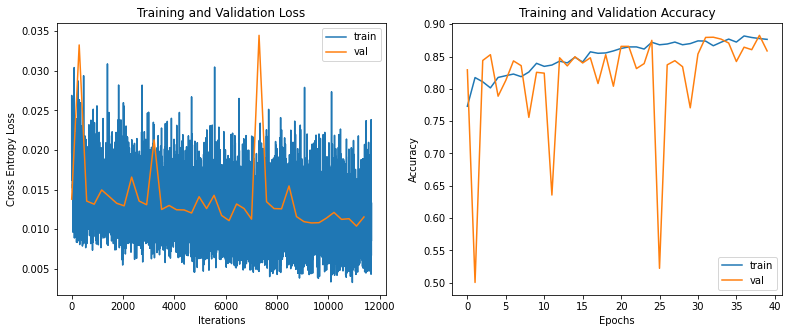

In [25]:
plot_comparison(train_dataloader, epochs, train_loss, val_loss, train_accuracy, val_accuracy)

## ResNet18

In [ ]:
from torchvision import models

dl_models = dir(models)

# Looking for ResNet functions
result = [i for i in dl_models if i.startswith('r')]
result

In [ ]:
# Load the ResNet Network
resnet18 = models.resnet18(pretrained=False) # to train using our data
# resnet18_trained = models.resnet18(pretrained=True) # use the pretrained model

# Freezing Layers
for param in resnet18.parameters():
    param.requires_grad = False

# Modifying the Last Layer
fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True), nn.LogSoftmax(dim=1)) # 512 neurons, 2 classes

#Attaching custom classifier to the model
resnet18.fc = fc

resnet18

In [ ]:
train_loss = [] # where we keep track of the training loss
train_accuracy = [] # where we keep track of the training accuracy of the model
val_loss = [] # where we keep track of the validation loss
val_accuracy = [] # where we keep track of the validation accuracy of the model
epochs = 40 # number of epochs

model = resnet18
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, verbose = True)


for e in range(epochs):
    
  epoch_train_loss, epoch_train_accuracy, mean_loss= train_epoch(model, optimizer, loss_func, train_dataloader, device)
  epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, test_dataloader, device, scheduler=scheduler)
  print(f'epoch: {e} training loss: {mean_loss}')

  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

In [ ]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataloader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataloader),len(train_dataloader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(list(range(epochs)), train_accuracy, label="train")
plt.plot(list(range(epochs)),val_accuracy, label="val")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Resnext101_32x4d

In [ ]:
# # Load the ResNet Network
# resnet18 = models.resnet18(pretrained=False) # to train using our data
# # resnet18_trained = models.resnet18(pretrained=True) # use the pretrained model

# # Freezing Layers
# for param in resnet18.parameters():
#     param.requires_grad = False

# # Modifying the Last Layer
# fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True), nn.LogSoftmax(dim=1)) # 512 neurons, 2 classes

# #Attaching custom classifier to the model
# resnet18.fc = fc

# resnet18

## Models Evaluation 

In [ ]:
# Accuracy 

# Inference time

In [ ]:
# To do
# Implement ResNET18
# further divide into testing and training 
# Save LeNet7